In [2]:
%matplotlib inline
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import gym
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras

# 函数近似方法

## 使用环境：小车上山MountainCar-v0

* 一个小车在一定范围内行驶，在任意时刻，从水平方向看，小车的位置是[-1.2,0.6]，速度范围[-0.07,0.07]
* 每个时刻，智能体可以对小车施加3种动作中的一种：向左施力，不施力，向右施力。智能体的施力和小车的水平位置会共同决定下一时刻小车速度
* 当某时刻小车的水平位置大于0.5时，控制目标达成，回合结束。控制的目标是让小车以尽可能少的步骤叨叨目标。

In [3]:
env = gym.make("MountainCar-v0")
env.seed(0)
print("观测空间 = {}".format(env.observation_space))
print("动作空间 = {}".format(env.action_space))
print("位置范围 = {}".format((env.unwrapped.min_position, 
                             env.unwrapped.max_position)))
print("速度范围 = {}".format((-env.unwrapped.max_speed, 
                             env.unwrapped.max_speed)))
print("目标位置 = {}".format(env.unwrapped.goal_position))

观测空间 = Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
动作空间 = Discrete(3)
位置范围 = (-1.2, 0.6)
速度范围 = (-0.07, 0.07)
目标位置 = 0.5


在绝大多数情况下，智能体简单向右的施力不足以让小车越过目标。

失败退出


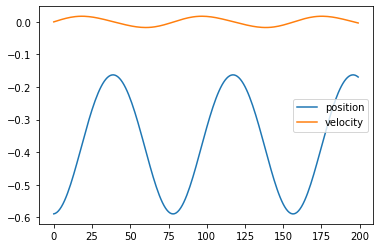

In [4]:
positions, velocities = [], []
observation = env.reset()
while True:
    positions.append(observation[0])
    velocities.append(observation[1])
    next_observation, reward, done, _ = env.step(2)
    if done:
        break
    observation = next_observation

if next_observation[0] > 0.5:
    print("成功到达")
else:
    print("失败退出")

# 绘制位置和速度图像
fig, ax = plt.subplots()
ax.plot(positions, label='position')
ax.plot(velocities, label='velocity')
ax.legend()


In [5]:
env.close()

## 函数近似原理

* 评估状态价值：用一个参数为$\bf{w}$的函数$v(s;\bold{w})$来近似

* 评估动作价值：用一个参数为$\bf{w}$的函数$q(s,a;\bold{w})$来近似

  动作集$A$有限时，还可以用矢量函数$q(s;\bold{w}) = \left( q(s,\bold{w}):a \in A \right)$来近似。每个元素对应一个动作，整个矢量函数除了参数外只用状态做输入。

* 形式不限，但是需要实现更新，学习过程中只更新$\bold{w}$。更新参数的方法既可用于策略价值评估，也可用于最优策略求解


### 随机梯度下降

* 同策回合更新价值估计与函数近似方法相结合，可以得到函数近似回合更新价值估计算法。与之前的区别在于价值更新时更新的对象是函数参数，而非价值估计

#### 算法1：随机梯度下降函数近似评估策略价值

1. 初始化：任意初始化参数$\bold{w}$
2. 逐回合执行以下操作：
   1. 采样：用环境和策略$\pi$生成轨迹样本
   2. 初始化回报：$G \leftarrow 0$
   3. 逐步更新：对$t = T-1,T-2,\dots,0$，执行以下步骤：
      1. 更新回报：$G \leftarrow \gamma G +R_{t+1}$
      2. 更新价值：若评估动作价值则更新$\bold{w}$以减小$[G - q(S_t,A_t;\bold{w})]^2$（如$\bold{w} \leftarrow \bold{w} + \alpha[G - q(S_t,A_t;\bold{w})]\nabla q(S_t,A_t;\bold{w})$）；若评估状态价值则更新$\bold{w}$以减小$[G - v(S_t;\bold{w})]^2$（如$\bold{w} \leftarrow \bold{w} + \alpha[G - v(S_t;\bold{w})]\nabla v(S_t;\bold{w})$）

【**随机梯度下降**】若采用以上算法评估动作价值，则更新参数时应当试图减小每一步的回报估计$G_t$和动作价值估计$q(S_t,A_t;\bold{w})$的差别。定义每一步的损失为$[G - q(S_t,A_t;\bold{w})]^2$，整个回合的损失为$\sum_{t=0}^{T-1}[G - q(S_t,A_t;\bold{w})]^2$。若沿着$\sum_{t=0}^{T-1}[G - q(S_t,A_t;\bold{w})]^2$对$\bold{w}$的梯度反方向更新策略参数$$\bold{w}$$，就有机会减小损失。这样的方法称为**随机梯度下降**
$$
\bold{w} \leftarrow \bold{w} - \frac{1}{2} \alpha_t \nabla[G - q(S_t,A_t;\bold{w})]^2 = \bold{w} + \alpha_t [G - q(S_t,A_t;\bold{w})]\nabla q(S_t,A_t;\bold{w})
$$
可利用支持自动梯度计算的软件包。状态价值类似。

将策略改进引入随机梯度下降评估策略，即可实现随机梯度下降最优策略求解。

#### 算法2：随机梯度下降求最优策略

1. 初始化：任意初始化参数$\bold{w}$
2. 逐回合执行以下操作：
   1. 采样：用环境和当前动作价值估计导出的策略生成轨迹样本
   2. 初始化回报：$G \leftarrow 0$
   3. 逐步更新：对$t = T-1,T-2,\dots,0$，执行以下步骤：
      1. 更新回报：$G \leftarrow \gamma G +R_{t+1}$
      2. 更新价值：若评估动作价值则更新$\bold{w}$以减小$[G - q(S_t,A_t;\bold{w})]^2$（如$\bold{w} \leftarrow \bold{w} + \alpha[G - q(S_t,A_t;\bold{w})]\nabla q(S_t,A_t;\bold{w})$）；若评估状态价值则更新$\bold{w}$以减小$[G - v(S_t;\bold{w})]^2$（如$\bold{w} \leftarrow \bold{w} + \alpha[G - v(S_t;\bold{w})]\nabla v(S_t;\bold{w})$）

### 半梯度下降

* 对于单步更新时序差分估计的动作价值函数：$U_t = R_{t+1} +\gamma q(S_{t+1},A_{t+1};\bold{w})$
* 动作价值的估计：$q(S_t,A_t;\bold{w})$
* 定义单步损失：$[U_t - q(S_t,A_t,\bold{w})]^2$；整个回合的损失：$\sum_{t=0}^{T-1} [U_t - q(S_t,A_t,\bold{w})]^2$

* 更新参数$\bold{w}$以减小损失时，不对回报的估计$U_t = R_{t+1} +\gamma q(S_{t+1},A_{t+1};\bold{w})$求梯度，支队动作价值估计求梯度，这就是**半梯度下降**

#### 算法3：半梯度下降算法估计动作价值或SARSA算法求最优策略

1. 初始化：任意初始化参数$\bold{w}$
2. 逐回合执行以下操作：
   1. 若为策略评估，则根据输入策略确定动作$A$；若为寻找最优策略，则用当前动作价值估计导出的策略确定动作$A$
   2. 若回合未结束，执行以下操作：
      1. 采样：执行动作$A$，观测得到奖励$R$和状态$S'$
      2. 若为策略评估，则根据输入策略确定动作$A'$；若为寻找最优策略，则用当前动作价值估计导出的策略确定动作$A'$
      3. 计算回报的估计值：$U \leftarrow R +\gamma q(S',A';\bold{w})$
      4. 更新动作价值函数：更新参数$\bold{w}$以减小$[U - q(S,A;\bold{w})]^2$（如$\bold{w} \leftarrow \bold{w} + \alpha[U - q(S_t,A_t;\bold{w})]\nabla q(S_t,A_t;\bold{w})$）。<u>此步不可重复计算$U$</u>
      5. $S \leftarrow S', A \leftarrow A'$

#### 算法4：半梯度下降算法估计状态价值或期望SARSA算法或Q学习

1. 初始化：任意初始化参数$\bold{w}$
2. 逐回合执行以下操作：
   1. 初始化状态：选择$S$
   2. 若回合未结束，执行以下操作：
      1. 若为策略评估，则根据输入策略确定动作$A$；若为寻找最优策略，则用当前动作价值估计导出的策略确定动作$A$
      2. 采样：执行动作$A$，观测得到奖励$R$和状态$S'$
      3. 计算回报的估计值
         * 若是状态价值评估，则$U \leftarrow R+\gamma v(S';\bold{w})$
         * 若是期望SARSA算法，则$U \leftarrow R+\gamma \sum_a \pi(a|S';\bold{w})q(S',a;\bold{w})$
         * 若是Q学习，则$U \leftarrow R +\gamma \max_a q(S',a;\bold{w})$
      4. 更新动作价值函数
         * 若是状态价值评估则更新$\bold{w}$以减小$[U - v(s;\bold{w})]^2$（如$\bold{w} \leftarrow \bold{w} + \alpha[U - v(S;\bold{w})]\nabla v(S;\bold{w}) $）
         * 若是期望SARSA算法或Q学习则更新参数$\bold{w}$以减小$[U - q(S,A;\bold{w})]^2$（如$\bold{w} \leftarrow \bold{w} + \alpha[U - q(S_t,A_t;\bold{w})]\nabla q(S_t,A_t;\bold{w})$）。<u>此步不可重复计算$U$</u>
      5. $S \leftarrow S'$

若采用自动计算微分并更新参数的包来减小损失，则务必注意不能对回报的估计求梯度。有些软件包可以组织计算过程中梯度的传播，也可以在计算回报估计的表达式时使用阻止梯度传播的功能。还有一种办法是复制一份参数$\bold w_{目标} = \bold{w}$，在计算回报估计的表达式时用这份复制后的参数$\bold{w}_{目标}$来计算回报估计

### 带资格迹的半梯度下降

资格迹参数$\bold{z}$和价值参数$\bold{w}$具有相同的形状大小，且元素逐一对应。资格迹参数中的每个元素表示了在更新价值参数对应元素时应当使用的权重乘以价值估计对该分量的梯度。

* 更新动作价值：$\bold{w} \leftarrow \bold{w} + \alpha[U - q(S_t,A_t;\bold{w})]$
* 更新状态价值：$\bold{w} \leftarrow \bold{w} + \alpha[U - v(S_t;\bold{w})]$

当选取资格迹为累积迹时，资格迹的递推定义式如下：

* $t = 0$时$\bold{z}_0 = 0$
* $t > 0$时：
  * 动作价值：$\bold{z}_t = \gamma \lambda \bold{z}_{t-1} +\nabla q(S_t,A_t;\bold{w})$
  * 状态价值：$\bold{z}_t = \gamma \lambda \bold{z}_{t-1} +\nabla v(S_t;\bold{w})$

递推式第一项：对前一次更新时使用的资格迹衰减而来，可以改变$\lambda$的值以改变衰减速度

递推式第二项：加强项，由动作价值的梯度决定，事实上确定了价值参数对总体价值估计的影响。

对总体价值估计影响大的那些价值参数分量是当前比较重要的分量，应当加强其资格迹。由于梯度可正可负可为0，因此更新后的资格迹可能为负数，对应价值参数分量的权重值就是负数。因此面对相同的时序差分误差，可能某些分量增加而某些分量减小

#### 算法5：TD($\lambda$)算法估计动作价值或SARSA($\lambda$)算法

1. 初始化：任意初始化参数$\bold{w}$
2. 逐回合执行以下操作：
   1. 初始化状态动作对：选择状态$S$
      * 若是策略评估，则根据输入策略确定动作$A$
      * 若是寻找最优策略，则用当前动作价值估计导出的策略确定动作$A$
   2. 若回合未结束，执行以下操作：
      1. 采样：执行动作$A$，观测得到奖励$R$和状态$S'$
      2. 若为策略评估，则根据输入策略确定动作$A'$；若为寻找最优策略，则用当前动作价值估计导出的策略确定动作$A'$
      3. 计算回报的估计值：$U \leftarrow R +\gamma q(S',A';\bold{w})$
      4. 更新资格迹：$\bold{z} \leftarrow \gamma\lambda\bold{z} +\nabla q(S,A;\bold{w})$
      5. 更新动作价值函数：$\bold{w} \leftarrow \bold{w} + \alpha[U - q(S,A;\bold{w})]\bold{z}$
      6. $S \leftarrow S', A \leftarrow A'$

#### 算法6：TD($\lambda$)算法估计状态价值或期望SARSA($\lambda$)算法或Q学习

1. 初始化：任意初始化参数$\bold{w}$
2. 逐回合执行以下操作：
   1. 初始化资格迹：$\bold{z} \leftarrow 0$
   2. 初始化状态：选择状态$S$
   3. 若回合未结束，执行以下操作：
      1. 若是策略评估，则根据输入策略确定动作$A$；若是寻找最优策略，则用当前动作价值估计导出的策略确定动作$A$
      2. 采样：执行动作$A$，观测得到奖励$R$和状态$S'$
      3. 计算回报的估计值
         * 若是状态价值评估，则$U \leftarrow R+\gamma v(S';\bold{w})$
         * 若是期望SARSA算法，则$U \leftarrow R+\gamma \sum_a \pi(a|S';\bold{w})q(S',a;\bold{w})$
         * 若是Q学习，则$U \leftarrow R +\gamma \max_a q(S',a;\bold{w})$
      4. 更新资格迹
         * 若是状态价值评估则$\bold{z} \leftarrow \gamma \lambda\bold{z} +\nabla v(S;\bold{w})$
         * 若是期望SARSA算法或Q学习则$\bold{z} \leftarrow \gamma \lambda\bold{z} +\nabla q(S,A;\bold{w})$
      5. 更新动作价值函数
         * 若是状态价值评估则更新$\bold{w}$以减小$[U - v(s;\bold{w})]^2$（如$\bold{w} \leftarrow \bold{w} + \alpha[U - v(S;\bold{w})]\bold{z} $）
         * 若是期望SARSA算法或Q学习则更新参数$\bold{w}$以减小$[U - q(S,A;\bold{w})]^2$（如$\bold{w} \leftarrow \bold{w} + \alpha[U - q(S_t,A_t;\bold{w})]bold{z}$）。<u>此步不可重复计算$U$</u>
      6. $S \leftarrow S'$

## 线性近似

【**线性近似**】用许多特征向量的线性组合来近似价值函数。特征向量则依赖于输入（状态或状态动作对）

> 以动作价值为例，可为每个状态动作对定义多个不同的特征$\bold{x}(s,a) = (x_j(s,a):j\in J)$，进而定义近似函数为这些特征的线性组合，即：
> $$
> q(s,a;\bold{w}) = [\bold{x}(s,a)]^T\bold{w} = \sum_{j \in J}x_j(s,a)w_j
> $$
> 对于状态函数：
> $$
> v(s;\bold{w}) = [\bold{x}(s)]^T\bold{w} = \sum_{j \in J}x_j(s)w_j
> $$

### 精确查表与线性近似的关系

3~5章的查表法可看作线性近似的特例。对于动作价值而言，可以认为有$|S|\times|A|$个特征向量，只在某个状态动作对出为1，其余全为0。此时，所有向量的线性组合就是整个动作价值函数，线性组合系数的值就是动作价值函数的值。

### 线性最小二乘策略评估

线性最小二乘是一种批处理(batch)的方法，它每次针对多个经验样本，试图找到整个样本集上的最优估计

【**线性最小二乘回合更新**】（LSMC）其试图最小化
$$
L(\bold{w}) = \sum_t [G_t - q(S,A;\bold{W})]^2
$$
在线性近似的情形下，其梯度为
$$
\begin{aligned}
&\sum_t [G_t - q(S_t,A_t;\bold{w})] \nabla q(S_t,A_t;\bold{w}) \\
&=\sum_t [G_t - (\bold{x}(S_t,A_t))^T \bold{w}]\bold{x}(S_t,A_t)\\
&=\sum_tG_t\bold{x}(S_t,A_t) - \sum_t \bold{x}(S_t,A_t)(\bold{x}(S_t,A_t))^T\bold{w}
\end{aligned}
$$
将待求权重$\bold{w}_{LSMC}$代入并令上式为0，则：
$$
\sum_tG_t\bold{x}(S_t,A_t) - \sum_t \bold{x}(S_t,A_t)(\bold{x}(S_t,A_t))^T\bold{w}_{LSMC} =0
$$
得：
$$
\bold{w}_{LSMC} = \left(\sum_t \bold{x}(S_t,A_t)(\bold{x}(S_t,A_t))^T\right)^{-1}\sum_tG_t\bold{x}(S_t,A_t)
$$
由此得到线性最小二乘回合更新的计算式子。可直接利用上式更新权重

【**线性最小二乘时序差分更新**】（LSTD）其试图最小化
$$
L(\bold{w}) = \sum_t [U_t - q(S,A;\bold{W})]^2
$$
求其半梯度，并令其等于0，得：
$$
\bold{w}_{LSTD} = \left(\sum_t \bold{x}(S_t,A_t)(\bold{x}(S_t,A_t)-\gamma\bold{x}(S_{t+1},A_{t+1}))^T\right)^{-1}\sum_tR_{t+1}\bold{x}(S_t,A_t)
$$

### 线性最小二乘最优策略求解

Q学习中，回报的估计为$U_t = R_{t+1} +\gamma \max_{a\in A(S_{t+1})} q(S_{t+1},a;\bold{w})$

相比于时序差分：将$A_{t+1}$换位$A_{t+1}^* = \mathop{\arg\max}_a q(S_{t+1},a;\bold{w})$

因此：
$$
\bold{w}_{LSTDQ} = \left(\sum_t \bold{x}(S_t,A_t)(\bold{x}(S_t,A_t)-\gamma\bold{x}(S_{t+1},A_{t+1}^*))^T\right)^{-1}\sum_tR_{t+1}\bold{x}(S_t,A_t)
$$
求解上述最小二乘解，可得到最优价值函数的估计，进而得到最优策略的更新。据此策略反复迭代即可得到线性最小二乘Q学习

#### 算法7：线性最小二乘Q学习算法求解最优策略

【输入】许多经验

【输出】最优动作价值估计和确定性最优策略估计

1. 初始化：$\bold{w} \leftarrow any$，用最优价值函数确定贪心策略$\pi$
2. 迭代更新：迭代进行以下操作：
   1. 更新价值：$\bold{w}' \leftarrow  \left(\sum_t \bold{x}(S_t,A_t)(\bold{x}(S_t,A_t)-\gamma\bold{x}(S_{t+1},A_{t+1}^*))^T\right)^{-1}\sum_tR_{t+1}\bold{x}(S_t,A_t)$，其中$A_{t+1}^*$是由确定性策略$\pi$决定的在状态$S_{t+1}$的动作
   2. 策略改进：据最优价值函数决定策略$\pi$
   3. 任意达到迭代终止条件（如$\bold{w}$和$\bold{w}'$足够接近，或$\pi$和$\pi'$足够接近），则终止迭代；否则更新二者，进行下一轮迭代

### 独热编码和砖瓦编码

在小车上山问题中，位置和速度都是连续变量，要从连续空间中导出数目有限的特征：
【**独热编码**】在二维的位置-速度空间中，将其划分成若干小格。位置轴范围总长是$l_{位置}$，每个小格的宽度为$\delta_{位置}$，共有$b_{位置} = l_{位置} / \delta_{位置}$个小格。同理有$l_{速度}$、$\delta_{速度}$以及$b_{速度}$。由此整个空间有$b_{位置}b_{速度}$个小格。每个小格对应一个特征，当位置速度对位于某个小格时，那个小格对应的位置特征为1，其余小格对应的特征均为0。由此提取出$b_{位置}b_{速度}$个特征。

采用独热编码后的价值函数，对于同一小格内的所有位置速度对，其价值函数估计相同，因此只是一种近似。若想让近似更精确，则需增大特征数目

【**砖瓦编码**】在精度相同情况下减少特征数目。在独热编码基础上引入多层大网格。采用$m$层砖瓦编码，每层的大网格都是原来独热编码小格的$m$位长，$m$位宽。在相邻两层之间，在两个维度上都偏移一个独热编码的小格，对于任意的位置速度对，它在每一层都会落到某个大网格中。这样，我们可以让每层中大网格对应的特征为1，其他特征为0.综合考虑所有层，总共大致有$b_{位置}b_{速度}/m$个特征，特征数大大减小。

In [6]:
# 线性最优策略求解，砖瓦编码
class TileCoder:
    def __init__(self, layers, features):
        self.layers = layers
        self.features = features
        self.codebook = {}

    def get_feature(self, codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]
        count = len(self.codebook)
        if count >= self.features: # 冲突处理
            return hash(codeword) % self.features
        self.codebook[codeword] = count
        return count

    def __call__(self,floats=(), ints=()):
        dim = len(floats)
        scaled_floats = tuple(f * self.layers * self.layers for f in floats)
        features = []
        for layer in range(self.layers):
            codeword = (layer,) + tuple(int((f + (1 + dim * i) * layer ) / 
                       self.layers) for i, f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features

In [7]:
class SARSAAgent:
    def __init__(self, env, layers=8, features=1893, gamma=1.,
                lr = 0.03, epsilon=0.001):
        self.action_n = env.action_space.n  # 动作数
        self.obs_low = env.observation_space.low
        self.obs_scale = env.observation_space.high - \
                        env.observation_space.low   # 观测空间范围
        self.encoder = TileCoder(layers, features)  # 砖瓦编码器
        self.w = np.zeros(features) # 权重
        self.gamma = gamma          # 折扣            
        self.lr = lr                # 学习率
        self.epsilon = epsilon      # 探索

    def encode(self, observation, action):  # 编码
        states = tuple((observation - self.obs_low) / self.obs_scale)
        actions = (action, )
        return self.encoder(states, actions)

    def get_q(self, observation, action):   # 动作价值
        features = self.encode(observation, action)
        return self.w[features].sum()

    def decide(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_n)
        else:
            qs = [self.get_q(observation, action) for action in 
                    range(self.action_n)]
        return np.argmax(qs)
    
    def learn(self, observation, action, reward, next_observation,
                done, next_action):
        u = reward + (1 - done) * self.gamma * \
                self.get_q(next_observation,next_action)
        td_error = u - self.get_q(observation, action)
        features = self.encode(observation, action)
        self.w[features] += self.lr * td_error

In [8]:
def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    while True:
        if render:
            env.render()
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        next_action = agent.decide(next_observation) # 终止状态时此步无意义
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done, next_action)
        if done:
            break
        observation, action = next_observation, next_action
    return episode_reward

平均回合奖励 = -11664.0 / 100 = -116.64


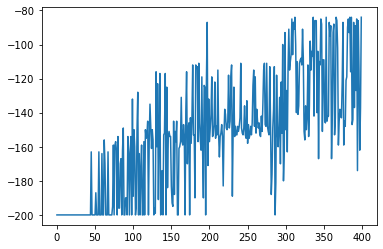

In [9]:
agent = SARSAAgent(env)

# 训练
episodes = 400
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

In [10]:
class SARSALambdaAgent(SARSAAgent):
    def __init__(self, env, layers=8, features=1893, gamma=1, lr=0.03,
                epsilon=0.001, lambd=0.9):
        super().__init__(env,layers,features,gamma,lr,epsilon)
        self.lambd = lambd
        self.z = np.zeros(features) # 初始化资格迹

    def learn(self, observation, action, reward, next_observation, done, next_action):
        u = reward
        if not done:
            u += self.gamma * self.get_q(next_observation, next_action)
            self.z *= self.gamma * self.lambd
            features = self.encode(observation, action)
            self.z[features] = 1 # 替换迹
        td_error = u - self.get_q(observation, action)
        self.w += self.lr * td_error * self.z
        if done:
            self.z = np.zeros_like(self.z)

平均回合奖励 = -11130.0 / 100 = -111.3


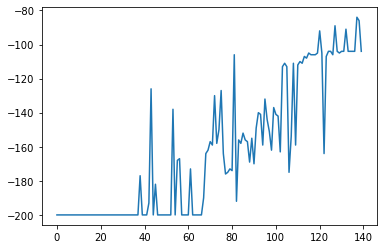

In [11]:
agent = SARSALambdaAgent(env)

# 训练
episodes = 140
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

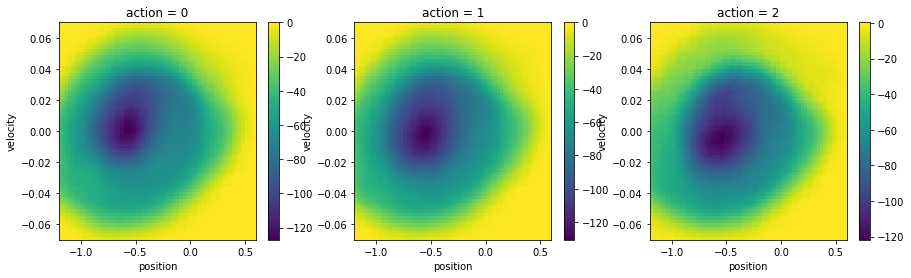

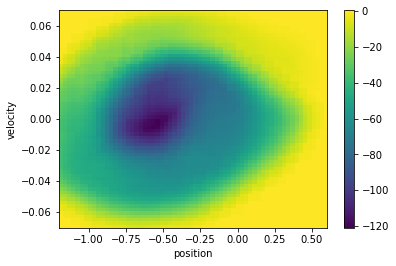

In [12]:
poses = np.linspace(env.unwrapped.min_position,
          env.unwrapped.max_position, 128)
vels = np.linspace(-env.unwrapped.max_speed, env.unwrapped.max_speed, 128)
positions, velocities = np.meshgrid(poses, vels)

# 绘制动作价值估计

@np.vectorize
def get_q(position, velocity, action):
    return agent.get_q((position, velocity), action)

q_values = np.empty((len(poses), len(vels), 3))
for action in range(3):
    q_values[:, :, action] = get_q(positions, velocities, action)


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for action, ax in enumerate(axes):
    c = ax.pcolormesh(positions, velocities, q_values[:, :, action], shading='auto')
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')
    fig.colorbar(c, ax=ax)
    ax.set_title('action = {}'.format(action))

# 绘制状态价值估计

v_values = q_values.max(axis=-1)

fig, ax = plt.subplots(1, 1)
c = ax.pcolormesh(positions, velocities, v_values, shading='auto')
ax.set_xlabel('position')
ax.set_ylabel('velocity')
fig.colorbar(c, ax=ax);

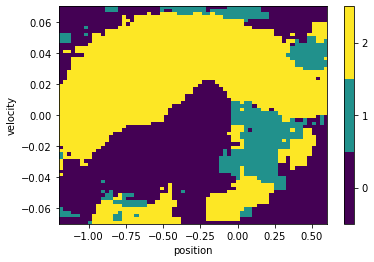

In [13]:
# 绘制动作估计

@np.vectorize
def decide(position, velocity):
    return agent.decide((position, velocity))

q_values = np.empty((len(poses), len(vels), 3))
action_values = decide(positions, velocities)

fig, ax = plt.subplots()
c = ax.pcolormesh(positions, velocities, action_values, shading='auto')
ax.set_xlabel('position')
ax.set_ylabel('velocity')
fig.colorbar(c, ax=ax, boundaries=[-.5, .5, 1.5, 2.5], ticks=[0, 1, 2]);

## 函数近似的收敛性

线性近似具有简单的线性叠加结构，这使得线性近似可以获得额外的收敛性；对于函数近似算法，收敛性往往只在采用梯度下降的回合更新时有保证，而在采用半梯度下降的时序差分方法时是没有保证的。各种收敛情况在下列表中给出，其中查表法是指不采用函数近似的方法；所有的收敛性都是在学习率满足 Robbins-Monro 序列下才具有的，且一般都可以通过验证随机近似  Robbins-Monro 算法的条件证明，对于最优策略求解的收敛性证明，则需要用到了其随机优化的版本。

| 学习方法 |                          | 查表法 | 线性近似   | 非线性近似 |
| -------- | ------------------------ | ------ | ---------- | ---------- |
| 同策     | 回合更新                 | 收敛   | 收敛       | 收敛       |
|          | 线性最小二乘回合更新     | 收敛   | 收敛       | 不适用     |
|          | 时序差分更新             | 收敛   | 收敛       | 不一定收敛 |
|          | 线性最小二乘时序差分更新 | 收敛   | 收敛       | 不适用     |
| 异策     | 回合更新                 | 收敛   | 收敛       | 收敛       |
|          | 线性最小二乘回合更新     | 收敛   | 收敛       | 不适用     |
|          | 时序差分更新             | 收敛   | 不一定收敛 | 不一定收敛 |
|          | 线性最小二乘时序差分更新 | 收敛   | 收敛       | 不适用     |

| 学习方法         | 查表法 | 线性近似               | 非线性近似 |
| ---------------- | ------ | ---------------------- | ---------- |
| 回合更新         | 收敛   | 收敛或在最优解附近摆动 | 不一定收敛 |
| SARSA            | 收敛   | 收敛或在最优解附近摆动 | 不一定收敛 |
| Q 学习           | 收敛   | 不一定收敛             | 不一定收敛 |
| 最小二乘迭代更新 | 收敛   | 收敛或在最优解附近摆动 | 不适用     |

值得一提的是，对于异策 Q 学习，即使采用了线性近似，仍然不能保证收敛。研究人员发现，只要异策、自益、函数近似这三者同时出现，就不能保证收敛性，但有一个著名的反例叫做 Baird 反例（Baird's counterexample）。

## 深度Q学习

* 深度学习与强化学习相结合，是第一个深度强化学习算法
* 核心：用一个人工神经网络$q(s,a;\bold{w})$来代替动作价值函数。由于神经网络具有强大的表达能力，能够自动寻找特征，因此有很大的潜力

* 同时出现异策、自益、函数近似时无法保证收敛性，会出现训练不稳定或训练困难的情况，目前主要的改进：
  1. **经验回放**：将经验（即历史的状态、动作、奖励等）存储起来，再在存储的经验中按一定规则采样
  2. **目标网络**：修改网络的更新方式，例如不把学习到的网络权重马上用于后续的自益过程

### 经验回放

采用批处理的模式能提高稳定性，经验回放就是一种让经验概率分布变得稳定的技术，它可以提高训练的稳定性

【**关键步骤**】

* 存储：将轨迹以$(S_t,A_t,R_{t+1},S_{t+1})$的形式存储起来
* 采样回放：使用某种规则从存储的$(S_t,A_t,R_{t+1},S_{t+1})$中随机取出一条或多条经验

#### 算法8：带经验回放的Q学习最优策略求解

1.  初始化：任意初始化参数$\bold{w}$
2. 逐回合执行以下操作：
   1. 初始化状态：选择状态$S$
   2. 若回合未结束，执行以下操作：
      1. 采样：根据$q(S,\cdot;\bold{w})$选择动作$A$并执行，观测得到奖励$R$和新状态$S'$
      2. 存储：将经验$(S,A,R,S')$存入经验库中
      3. 回放：从经验库中选取经验$(S_i,A_i,R_i,S_i')$
      4. 计算回报的估计值：$U_i \leftarrow R_i + \gamma \max_a q(S'_i,)$
      5. 更新动作价值函数：更新$\bold{w}$以减小$[U_i - q(S_i,A_i;\bold{w})]^2$（如$\bold{w} \leftarrow \bold{w} + \alpha[U_i - q(S_i,A_i;\bold{w})]\nabla q(S_i,A_i;\bold{w}) $）
      6. $S \leftarrow S'$

【**好处**】

1. 训练Q网络时可消除数据的关联，使得数据更像是独立同分布，以减小参数更新的方差，加速收敛
2. 能够重复使用经验，对于数据获取困难的情况尤其适用

【**分类**】

1. 从存储角度：

   * **集中式回放**：智能体在一个环境中运行，将经验统一存储于经验池中
   * **分布式回放**：智能体的多份拷贝同时在多个环境中运行，并将经验统一存储于经验池中。由于多个智能体拷贝同时生成经验，所以能够在使用更多资源的同时更快地收集经验

2. 从采样角度：

   * **均匀回放**：等概率从经验集中选取经验，并用取得的经验更新最优价值函数

   * **优先回放**（PER）：为经验池里的每个经验指定一个优先级，在选取经验时更倾向于选择优先级高的经验

     一般做法：若某个经验$i$的优先级为$p_i$，则选取该经验的概率为$\frac{p_i}{\sum_kp_k}$

     * <u>成比例优先</u>：第$i$个经验的优先级为
       $$
       p_i = (\delta_i +\varepsilon)^\alpha
       $$
       其中$\delta_i = U_t - q(S_t,A_t;\bold{w})$或$\delta_i = U_t - v(S_t;\bold{w})$为时序差分误差，$\varepsilon$是预先设定的小正数，$\alpha$为正参数

     * <u>基于排序优先</u>：第$i$个经验的优先级为
       $$
       p_i = \left(\frac{1}{\mathrm{rank}_i}\right)^\alpha
       $$
       其中$\mathrm{rank}_i$是第$i$个经验从大到小的排名，从1开始

分布式经验回放和优先回放结合：分布式优先经验回放

【**缺点**】会导致回合更新和多步学习算法无法使用。一般情况下与Q学习结合时可规避此缺点。

In [ ]:
# 用于画图的类
%matplotlib notebook

class Chart:
    def __init__(self):
        self.fig, self.ax = plt.subplots(1, 1)
        # plt.ion()
    
    def plot(self, episode_rewards):
        self.ax.clear()
        self.ax.plot(episode_rewards)
        self.ax.set_xlabel('iteration')
        self.ax.set_ylabel('episode reward')
        self.fig.canvas.draw()

In [ ]:
# 经验回放
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
            columns=['observation','action','reward','next_observation','done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity
    
    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)
    
    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)